# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

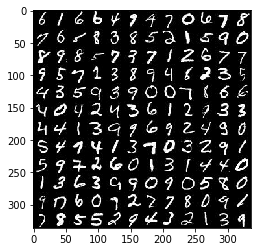

In [2]:
show_n_images = 150

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

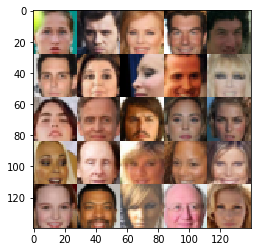

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [66]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, shape=[None, z_dim], name="inputs_z")
    learning_rate = tf.placeholder(tf.float32, shape=None, name="learning_rate")
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [86]:
def leaky_relu(alpha, x):
    return tf.maximum(alpha * x, x)

def make_conv_layer(x, filters, alpha, kernel=5, strides=2, padding="same", use_batch_norm=True):
        layer = tf.layers.conv2d(
            x, 
            filters,
            kernel, 
            strides=strides,
            padding=padding,
            kernel_initializer=tf.random_normal_initializer(stddev=0.02)
        )
        if use_batch_norm:
            layer = tf.layers.batch_normalization(layer, training=True)
        layer = leaky_relu(alpha, layer)
        
        return layer


def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boo|lean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        layer1 = make_conv_layer(images, 64, alpha, use_batch_norm=False)
        layer2 = make_conv_layer(layer1, 128, alpha)
        layer3 = make_conv_layer(layer2, 256, alpha, strides=1)

        flat = tf.reshape(layer3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [109]:
def make_conv_transpose_layer(x, filters, kernel=5, strides=2, padding="same", alpha=0.2, training=True):
        layer = tf.layers.conv2d_transpose(
            x,
            filters,
            kernel,
            strides=strides,
            padding=padding,
            kernel_initializer=tf.random_normal_initializer(stddev=0.02)
        )
        layer = tf.layers.batch_normalization(layer, training=training)
        layer = leaky_relu(alpha, layer)
        
        return layer

def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        layer1 = tf.layers.dense(z, 7*7*256)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 256))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = leaky_relu(alpha, layer1)
        
        layer2 = make_conv_transpose_layer(layer1, 128, training=is_train, alpha=alpha)
        
        layer3 = make_conv_transpose_layer(layer2, 64, training=is_train, alpha=alpha)
        logits =  tf.layers.conv2d_transpose(layer3, out_channel_dim, 3, strides=1, padding="same")
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [110]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [111]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [112]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [113]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    print("Image width {}, image height {} image channels {}".format(image_width, image_height, image_channels))
    print("z_dim {}".format(z_dim))
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    out_channel_dim = len(data_image_mode)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            i = 0
            for batch_images in get_batches(batch_size):
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if i % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if i % 50 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                i+=1
            show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Image width 28, image height 28 image channels 1
z_dim 100
Epoch 1/2... Batch 0... Discriminator Loss: 3.9565... Generator Loss: 0.0296


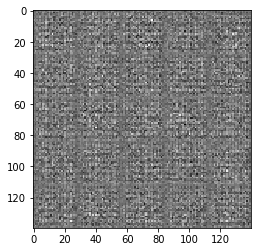

Epoch 1/2... Batch 10... Discriminator Loss: 0.6635... Generator Loss: 1.6545
Epoch 1/2... Batch 20... Discriminator Loss: 0.3902... Generator Loss: 3.1509
Epoch 1/2... Batch 30... Discriminator Loss: 0.3864... Generator Loss: 4.6203
Epoch 1/2... Batch 40... Discriminator Loss: 0.3890... Generator Loss: 3.5389
Epoch 1/2... Batch 50... Discriminator Loss: 4.2581... Generator Loss: 0.1147


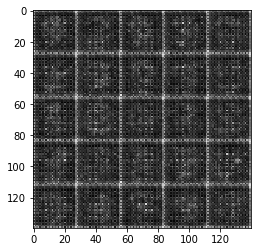

Epoch 1/2... Batch 60... Discriminator Loss: 2.3019... Generator Loss: 0.3132
Epoch 1/2... Batch 70... Discriminator Loss: 1.8012... Generator Loss: 0.8865
Epoch 1/2... Batch 80... Discriminator Loss: 1.2095... Generator Loss: 0.7584
Epoch 1/2... Batch 90... Discriminator Loss: 1.1024... Generator Loss: 1.1911
Epoch 1/2... Batch 100... Discriminator Loss: 0.8684... Generator Loss: 2.6831


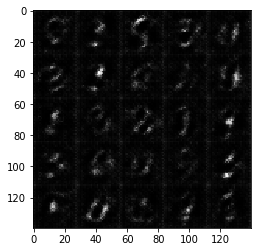

Epoch 1/2... Batch 110... Discriminator Loss: 0.5670... Generator Loss: 2.2351
Epoch 1/2... Batch 120... Discriminator Loss: 0.5165... Generator Loss: 1.9774
Epoch 1/2... Batch 130... Discriminator Loss: 3.1793... Generator Loss: 6.9361
Epoch 1/2... Batch 140... Discriminator Loss: 0.7248... Generator Loss: 1.2529
Epoch 1/2... Batch 150... Discriminator Loss: 1.8023... Generator Loss: 0.3293


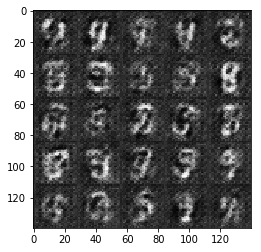

Epoch 1/2... Batch 160... Discriminator Loss: 1.3603... Generator Loss: 0.6282
Epoch 1/2... Batch 170... Discriminator Loss: 1.5780... Generator Loss: 2.8125
Epoch 1/2... Batch 180... Discriminator Loss: 0.9682... Generator Loss: 3.6905
Epoch 1/2... Batch 190... Discriminator Loss: 1.3073... Generator Loss: 0.5666
Epoch 1/2... Batch 200... Discriminator Loss: 1.0829... Generator Loss: 0.7807


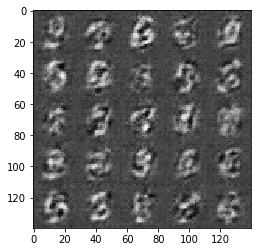

Epoch 1/2... Batch 210... Discriminator Loss: 0.7318... Generator Loss: 1.3283
Epoch 1/2... Batch 220... Discriminator Loss: 1.6114... Generator Loss: 0.3776
Epoch 1/2... Batch 230... Discriminator Loss: 0.8748... Generator Loss: 0.9998
Epoch 1/2... Batch 240... Discriminator Loss: 0.7364... Generator Loss: 1.4456
Epoch 1/2... Batch 250... Discriminator Loss: 0.9587... Generator Loss: 0.8401


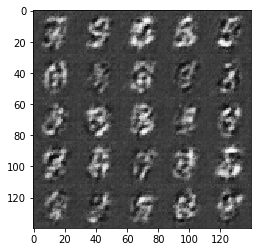

Epoch 1/2... Batch 260... Discriminator Loss: 0.5913... Generator Loss: 2.4181
Epoch 1/2... Batch 270... Discriminator Loss: 1.1618... Generator Loss: 0.6451
Epoch 1/2... Batch 280... Discriminator Loss: 0.7814... Generator Loss: 3.2084
Epoch 1/2... Batch 290... Discriminator Loss: 0.5772... Generator Loss: 2.0659
Epoch 1/2... Batch 300... Discriminator Loss: 1.0041... Generator Loss: 3.1655


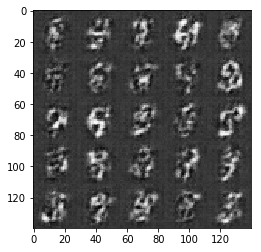

Epoch 1/2... Batch 310... Discriminator Loss: 1.4119... Generator Loss: 0.4992
Epoch 1/2... Batch 320... Discriminator Loss: 0.6676... Generator Loss: 1.4773
Epoch 1/2... Batch 330... Discriminator Loss: 0.9342... Generator Loss: 0.8863
Epoch 1/2... Batch 340... Discriminator Loss: 0.5262... Generator Loss: 2.3317
Epoch 1/2... Batch 350... Discriminator Loss: 0.5850... Generator Loss: 1.9986


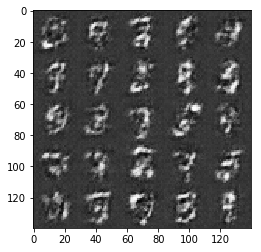

Epoch 1/2... Batch 360... Discriminator Loss: 0.7018... Generator Loss: 1.3564
Epoch 1/2... Batch 370... Discriminator Loss: 0.8036... Generator Loss: 1.0878
Epoch 1/2... Batch 380... Discriminator Loss: 0.5371... Generator Loss: 2.3580
Epoch 1/2... Batch 390... Discriminator Loss: 1.2830... Generator Loss: 0.5802
Epoch 1/2... Batch 400... Discriminator Loss: 0.6273... Generator Loss: 1.5683


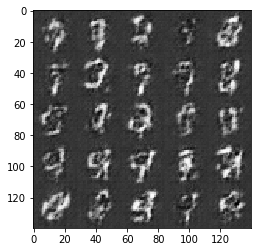

Epoch 1/2... Batch 410... Discriminator Loss: 0.5284... Generator Loss: 2.5598
Epoch 1/2... Batch 420... Discriminator Loss: 0.5425... Generator Loss: 1.9761
Epoch 1/2... Batch 430... Discriminator Loss: 0.6270... Generator Loss: 2.3750
Epoch 1/2... Batch 440... Discriminator Loss: 0.5598... Generator Loss: 1.8832
Epoch 1/2... Batch 450... Discriminator Loss: 0.4711... Generator Loss: 2.2935


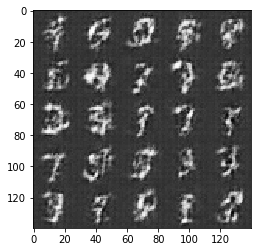

Epoch 1/2... Batch 460... Discriminator Loss: 1.1797... Generator Loss: 0.6768
Epoch 1/2... Batch 470... Discriminator Loss: 0.5971... Generator Loss: 1.7750
Epoch 1/2... Batch 480... Discriminator Loss: 0.6777... Generator Loss: 1.4130
Epoch 1/2... Batch 490... Discriminator Loss: 1.0899... Generator Loss: 0.7871
Epoch 1/2... Batch 500... Discriminator Loss: 0.6569... Generator Loss: 1.4611


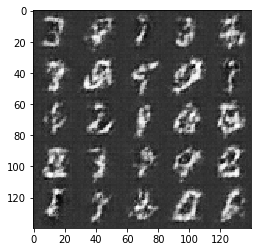

Epoch 1/2... Batch 510... Discriminator Loss: 0.9082... Generator Loss: 4.1143
Epoch 1/2... Batch 520... Discriminator Loss: 0.9793... Generator Loss: 0.8107
Epoch 1/2... Batch 530... Discriminator Loss: 0.7512... Generator Loss: 1.2671
Epoch 1/2... Batch 540... Discriminator Loss: 1.2306... Generator Loss: 0.6459
Epoch 1/2... Batch 550... Discriminator Loss: 1.0870... Generator Loss: 2.1320


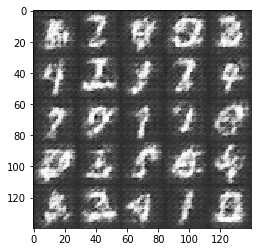

Epoch 1/2... Batch 560... Discriminator Loss: 1.3055... Generator Loss: 0.6618
Epoch 1/2... Batch 570... Discriminator Loss: 0.8807... Generator Loss: 1.2017
Epoch 1/2... Batch 580... Discriminator Loss: 0.7447... Generator Loss: 1.3513
Epoch 1/2... Batch 590... Discriminator Loss: 0.6938... Generator Loss: 1.3411
Epoch 1/2... Batch 600... Discriminator Loss: 0.6713... Generator Loss: 1.4029


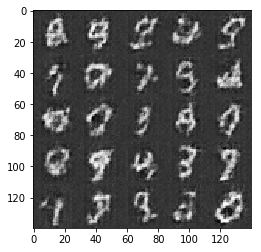

Epoch 1/2... Batch 610... Discriminator Loss: 0.7226... Generator Loss: 1.3575
Epoch 1/2... Batch 620... Discriminator Loss: 1.4320... Generator Loss: 0.4510
Epoch 1/2... Batch 630... Discriminator Loss: 0.6571... Generator Loss: 1.7154
Epoch 1/2... Batch 640... Discriminator Loss: 0.5660... Generator Loss: 2.0115
Epoch 1/2... Batch 650... Discriminator Loss: 1.0882... Generator Loss: 0.7460


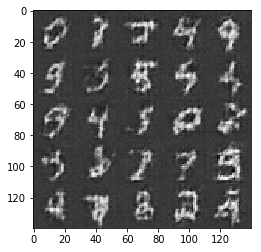

Epoch 1/2... Batch 660... Discriminator Loss: 0.8325... Generator Loss: 1.1050
Epoch 1/2... Batch 670... Discriminator Loss: 0.6044... Generator Loss: 1.6452
Epoch 1/2... Batch 680... Discriminator Loss: 1.2418... Generator Loss: 3.5639
Epoch 1/2... Batch 690... Discriminator Loss: 1.0356... Generator Loss: 0.7789
Epoch 1/2... Batch 700... Discriminator Loss: 0.6878... Generator Loss: 1.3912


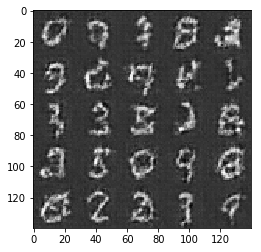

Epoch 1/2... Batch 710... Discriminator Loss: 0.7427... Generator Loss: 2.7155
Epoch 1/2... Batch 720... Discriminator Loss: 0.9323... Generator Loss: 1.0740
Epoch 1/2... Batch 730... Discriminator Loss: 0.7349... Generator Loss: 1.4421
Epoch 1/2... Batch 740... Discriminator Loss: 0.5478... Generator Loss: 2.0381
Epoch 1/2... Batch 750... Discriminator Loss: 0.7246... Generator Loss: 1.2700


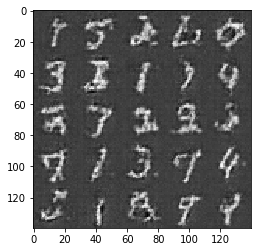

Epoch 1/2... Batch 760... Discriminator Loss: 0.8700... Generator Loss: 0.9869
Epoch 1/2... Batch 770... Discriminator Loss: 0.9046... Generator Loss: 0.9356
Epoch 1/2... Batch 780... Discriminator Loss: 0.9623... Generator Loss: 0.9020
Epoch 1/2... Batch 790... Discriminator Loss: 0.7313... Generator Loss: 1.2497
Epoch 1/2... Batch 800... Discriminator Loss: 0.6142... Generator Loss: 1.6894


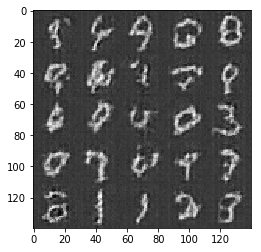

Epoch 1/2... Batch 810... Discriminator Loss: 5.0633... Generator Loss: 5.6662
Epoch 1/2... Batch 820... Discriminator Loss: 1.0652... Generator Loss: 1.3029
Epoch 1/2... Batch 830... Discriminator Loss: 0.8884... Generator Loss: 1.0674
Epoch 1/2... Batch 840... Discriminator Loss: 0.8542... Generator Loss: 1.0719
Epoch 1/2... Batch 850... Discriminator Loss: 0.8114... Generator Loss: 1.0918


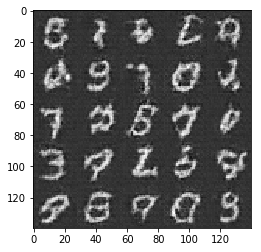

Epoch 1/2... Batch 860... Discriminator Loss: 0.5995... Generator Loss: 1.9417
Epoch 1/2... Batch 870... Discriminator Loss: 0.6731... Generator Loss: 1.3472
Epoch 1/2... Batch 880... Discriminator Loss: 0.4786... Generator Loss: 2.5075
Epoch 1/2... Batch 890... Discriminator Loss: 0.5907... Generator Loss: 1.8490
Epoch 1/2... Batch 900... Discriminator Loss: 1.0450... Generator Loss: 2.2899


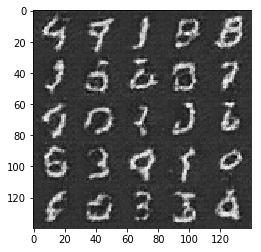

Epoch 1/2... Batch 910... Discriminator Loss: 0.8318... Generator Loss: 1.1866
Epoch 1/2... Batch 920... Discriminator Loss: 0.7822... Generator Loss: 1.2033
Epoch 1/2... Batch 930... Discriminator Loss: 0.7725... Generator Loss: 1.1959


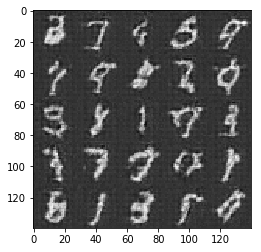

Epoch 2/2... Batch 0... Discriminator Loss: 0.8604... Generator Loss: 1.0055


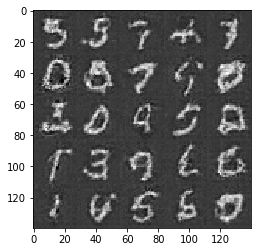

Epoch 2/2... Batch 10... Discriminator Loss: 0.4654... Generator Loss: 2.4714
Epoch 2/2... Batch 20... Discriminator Loss: 0.8808... Generator Loss: 1.0200
Epoch 2/2... Batch 30... Discriminator Loss: 0.5402... Generator Loss: 2.2916
Epoch 2/2... Batch 40... Discriminator Loss: 0.5746... Generator Loss: 1.7171
Epoch 2/2... Batch 50... Discriminator Loss: 0.6811... Generator Loss: 2.5528


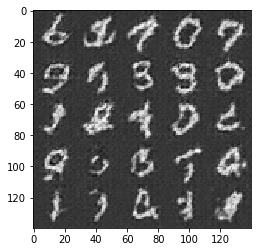

Epoch 2/2... Batch 60... Discriminator Loss: 0.6409... Generator Loss: 3.0341
Epoch 2/2... Batch 70... Discriminator Loss: 1.3237... Generator Loss: 0.5596
Epoch 2/2... Batch 80... Discriminator Loss: 0.7012... Generator Loss: 1.4040
Epoch 2/2... Batch 90... Discriminator Loss: 1.0643... Generator Loss: 1.1811
Epoch 2/2... Batch 100... Discriminator Loss: 1.2829... Generator Loss: 0.6014


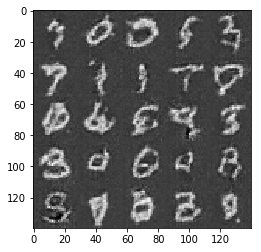

Epoch 2/2... Batch 110... Discriminator Loss: 0.9319... Generator Loss: 0.8972
Epoch 2/2... Batch 120... Discriminator Loss: 0.7511... Generator Loss: 1.2324
Epoch 2/2... Batch 130... Discriminator Loss: 0.5931... Generator Loss: 1.7207
Epoch 2/2... Batch 140... Discriminator Loss: 0.7491... Generator Loss: 1.2179
Epoch 2/2... Batch 150... Discriminator Loss: 0.6639... Generator Loss: 1.6587


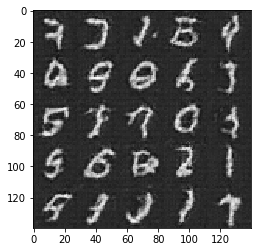

Epoch 2/2... Batch 160... Discriminator Loss: 1.2051... Generator Loss: 0.7138
Epoch 2/2... Batch 170... Discriminator Loss: 0.5442... Generator Loss: 1.9124
Epoch 2/2... Batch 180... Discriminator Loss: 0.6750... Generator Loss: 1.4279
Epoch 2/2... Batch 190... Discriminator Loss: 0.5685... Generator Loss: 1.8734
Epoch 2/2... Batch 200... Discriminator Loss: 2.3246... Generator Loss: 2.1680


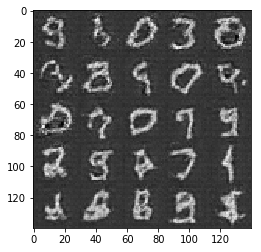

Epoch 2/2... Batch 210... Discriminator Loss: 1.0760... Generator Loss: 1.3563
Epoch 2/2... Batch 220... Discriminator Loss: 0.9377... Generator Loss: 1.0872
Epoch 2/2... Batch 230... Discriminator Loss: 1.3783... Generator Loss: 0.5203
Epoch 2/2... Batch 240... Discriminator Loss: 0.9461... Generator Loss: 1.1628
Epoch 2/2... Batch 250... Discriminator Loss: 0.7441... Generator Loss: 1.2868


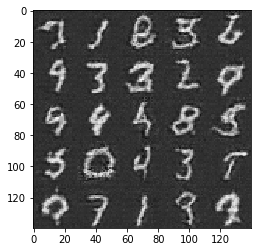

Epoch 2/2... Batch 260... Discriminator Loss: 0.6378... Generator Loss: 1.5218
Epoch 2/2... Batch 270... Discriminator Loss: 0.8333... Generator Loss: 1.0750
Epoch 2/2... Batch 280... Discriminator Loss: 0.7995... Generator Loss: 1.1200
Epoch 2/2... Batch 290... Discriminator Loss: 0.5637... Generator Loss: 2.5782
Epoch 2/2... Batch 300... Discriminator Loss: 1.4359... Generator Loss: 0.6937


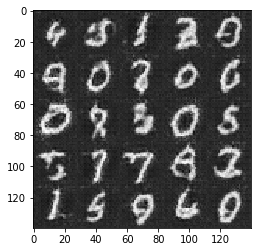

Epoch 2/2... Batch 310... Discriminator Loss: 0.9341... Generator Loss: 1.0477
Epoch 2/2... Batch 320... Discriminator Loss: 1.8164... Generator Loss: 0.3444
Epoch 2/2... Batch 330... Discriminator Loss: 0.6022... Generator Loss: 2.0576
Epoch 2/2... Batch 340... Discriminator Loss: 0.6617... Generator Loss: 1.5552
Epoch 2/2... Batch 350... Discriminator Loss: 0.4554... Generator Loss: 3.5343


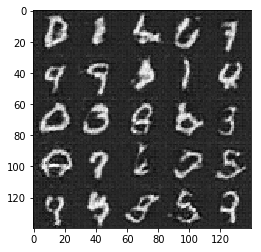

Epoch 2/2... Batch 360... Discriminator Loss: 1.0985... Generator Loss: 0.7095
Epoch 2/2... Batch 370... Discriminator Loss: 0.4502... Generator Loss: 2.8771
Epoch 2/2... Batch 380... Discriminator Loss: 0.4389... Generator Loss: 2.7161
Epoch 2/2... Batch 390... Discriminator Loss: 0.5951... Generator Loss: 1.6862
Epoch 2/2... Batch 400... Discriminator Loss: 0.4197... Generator Loss: 2.8447


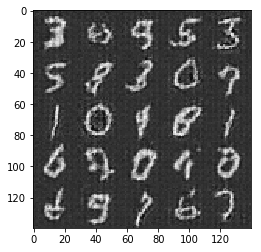

Epoch 2/2... Batch 410... Discriminator Loss: 0.5175... Generator Loss: 2.1273
Epoch 2/2... Batch 420... Discriminator Loss: 0.7241... Generator Loss: 1.3252
Epoch 2/2... Batch 430... Discriminator Loss: 0.9528... Generator Loss: 0.8768
Epoch 2/2... Batch 440... Discriminator Loss: 0.5323... Generator Loss: 2.0910
Epoch 2/2... Batch 450... Discriminator Loss: 0.4307... Generator Loss: 2.9357


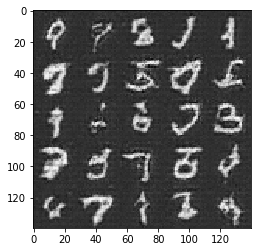

Epoch 2/2... Batch 460... Discriminator Loss: 0.3965... Generator Loss: 3.1681
Epoch 2/2... Batch 470... Discriminator Loss: 0.5877... Generator Loss: 1.6739
Epoch 2/2... Batch 480... Discriminator Loss: 0.3993... Generator Loss: 3.8329
Epoch 2/2... Batch 490... Discriminator Loss: 3.3324... Generator Loss: 2.0914
Epoch 2/2... Batch 500... Discriminator Loss: 1.0480... Generator Loss: 1.9093


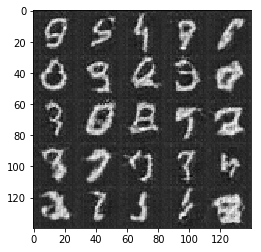

Epoch 2/2... Batch 510... Discriminator Loss: 1.0207... Generator Loss: 1.6457
Epoch 2/2... Batch 520... Discriminator Loss: 1.0187... Generator Loss: 1.0712
Epoch 2/2... Batch 530... Discriminator Loss: 0.8210... Generator Loss: 1.3921
Epoch 2/2... Batch 540... Discriminator Loss: 0.9687... Generator Loss: 2.0544
Epoch 2/2... Batch 550... Discriminator Loss: 0.6998... Generator Loss: 2.0220


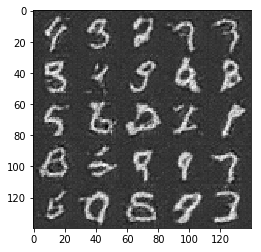

Epoch 2/2... Batch 560... Discriminator Loss: 1.2684... Generator Loss: 2.6551
Epoch 2/2... Batch 570... Discriminator Loss: 0.9271... Generator Loss: 0.9642
Epoch 2/2... Batch 580... Discriminator Loss: 0.4782... Generator Loss: 3.0532
Epoch 2/2... Batch 590... Discriminator Loss: 0.4161... Generator Loss: 3.0937
Epoch 2/2... Batch 600... Discriminator Loss: 0.4430... Generator Loss: 2.5198


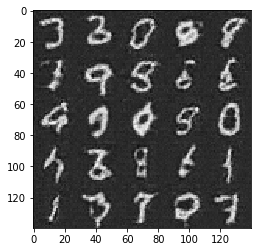

Epoch 2/2... Batch 610... Discriminator Loss: 0.5629... Generator Loss: 2.1010
Epoch 2/2... Batch 620... Discriminator Loss: 1.1536... Generator Loss: 0.7493
Epoch 2/2... Batch 630... Discriminator Loss: 1.1043... Generator Loss: 0.9045
Epoch 2/2... Batch 640... Discriminator Loss: 0.7615... Generator Loss: 1.5282
Epoch 2/2... Batch 650... Discriminator Loss: 1.1285... Generator Loss: 0.8056


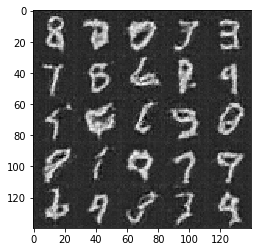

Epoch 2/2... Batch 660... Discriminator Loss: 1.8393... Generator Loss: 0.3370
Epoch 2/2... Batch 670... Discriminator Loss: 0.7935... Generator Loss: 1.2522
Epoch 2/2... Batch 680... Discriminator Loss: 0.6964... Generator Loss: 1.6591
Epoch 2/2... Batch 690... Discriminator Loss: 1.1545... Generator Loss: 3.2814
Epoch 2/2... Batch 700... Discriminator Loss: 0.9993... Generator Loss: 0.8501


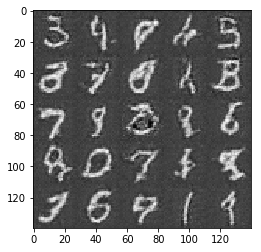

Epoch 2/2... Batch 710... Discriminator Loss: 1.1478... Generator Loss: 3.8922
Epoch 2/2... Batch 720... Discriminator Loss: 1.2685... Generator Loss: 2.4407
Epoch 2/2... Batch 730... Discriminator Loss: 0.7206... Generator Loss: 1.4425
Epoch 2/2... Batch 740... Discriminator Loss: 1.5478... Generator Loss: 0.4240
Epoch 2/2... Batch 750... Discriminator Loss: 1.7861... Generator Loss: 0.3471


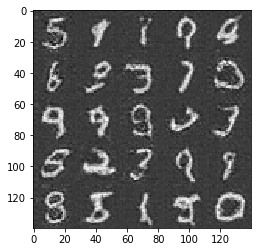

Epoch 2/2... Batch 760... Discriminator Loss: 0.4679... Generator Loss: 2.7448
Epoch 2/2... Batch 770... Discriminator Loss: 0.5406... Generator Loss: 2.0446
Epoch 2/2... Batch 780... Discriminator Loss: 0.4490... Generator Loss: 2.8384
Epoch 2/2... Batch 790... Discriminator Loss: 0.8088... Generator Loss: 1.1288
Epoch 2/2... Batch 800... Discriminator Loss: 0.6149... Generator Loss: 1.6353


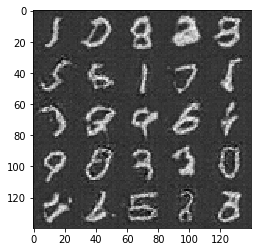

Epoch 2/2... Batch 810... Discriminator Loss: 0.4701... Generator Loss: 2.3492
Epoch 2/2... Batch 820... Discriminator Loss: 0.4070... Generator Loss: 3.8064
Epoch 2/2... Batch 830... Discriminator Loss: 1.1383... Generator Loss: 0.7093
Epoch 2/2... Batch 840... Discriminator Loss: 1.6493... Generator Loss: 0.7739
Epoch 2/2... Batch 850... Discriminator Loss: 1.2008... Generator Loss: 0.7554


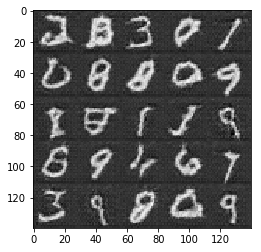

Epoch 2/2... Batch 860... Discriminator Loss: 1.4356... Generator Loss: 0.4973
Epoch 2/2... Batch 870... Discriminator Loss: 0.8597... Generator Loss: 1.3181
Epoch 2/2... Batch 880... Discriminator Loss: 0.6718... Generator Loss: 1.6493
Epoch 2/2... Batch 890... Discriminator Loss: 0.6032... Generator Loss: 1.7184
Epoch 2/2... Batch 900... Discriminator Loss: 1.0859... Generator Loss: 1.0923


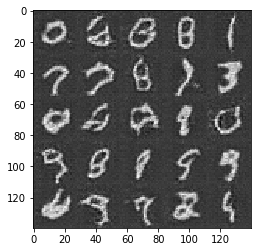

Epoch 2/2... Batch 910... Discriminator Loss: 0.7169... Generator Loss: 1.5860
Epoch 2/2... Batch 920... Discriminator Loss: 0.8683... Generator Loss: 1.0994
Epoch 2/2... Batch 930... Discriminator Loss: 0.6206... Generator Loss: 1.6312


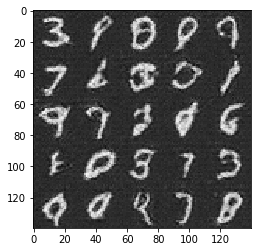

In [117]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take a|round 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Image width 28, image height 28 image channels 3
z_dim 100
Epoch 1/1... Batch 0... Discriminator Loss: 4.4251... Generator Loss: 0.0231


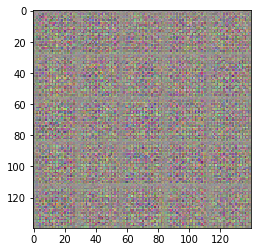

Epoch 1/1... Batch 10... Discriminator Loss: 2.7041... Generator Loss: 0.1646
Epoch 1/1... Batch 20... Discriminator Loss: 1.7531... Generator Loss: 0.4142
Epoch 1/1... Batch 30... Discriminator Loss: 1.9499... Generator Loss: 0.3509
Epoch 1/1... Batch 40... Discriminator Loss: 1.8864... Generator Loss: 0.3214
Epoch 1/1... Batch 50... Discriminator Loss: 1.1360... Generator Loss: 0.8013


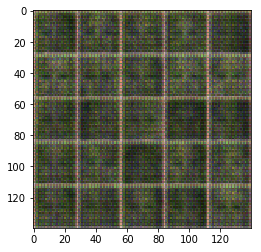

Epoch 1/1... Batch 60... Discriminator Loss: 2.2266... Generator Loss: 4.2221
Epoch 1/1... Batch 70... Discriminator Loss: 1.8846... Generator Loss: 0.3387
Epoch 1/1... Batch 80... Discriminator Loss: 1.7554... Generator Loss: 0.3506
Epoch 1/1... Batch 90... Discriminator Loss: 1.9154... Generator Loss: 0.5943
Epoch 1/1... Batch 100... Discriminator Loss: 1.4912... Generator Loss: 0.5566


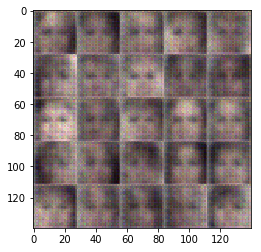

Epoch 1/1... Batch 110... Discriminator Loss: 1.8928... Generator Loss: 0.6544
Epoch 1/1... Batch 120... Discriminator Loss: 1.8469... Generator Loss: 0.3719
Epoch 1/1... Batch 130... Discriminator Loss: 1.5952... Generator Loss: 0.4399
Epoch 1/1... Batch 140... Discriminator Loss: 1.5094... Generator Loss: 0.8094
Epoch 1/1... Batch 150... Discriminator Loss: 0.9013... Generator Loss: 2.2807


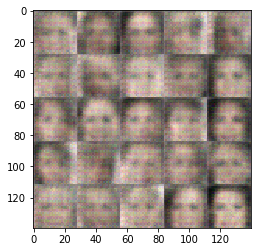

Epoch 1/1... Batch 160... Discriminator Loss: 1.4604... Generator Loss: 0.6623
Epoch 1/1... Batch 170... Discriminator Loss: 1.3275... Generator Loss: 0.8180
Epoch 1/1... Batch 180... Discriminator Loss: 2.3085... Generator Loss: 0.1875
Epoch 1/1... Batch 190... Discriminator Loss: 2.2921... Generator Loss: 0.2147
Epoch 1/1... Batch 200... Discriminator Loss: 1.9285... Generator Loss: 0.2744


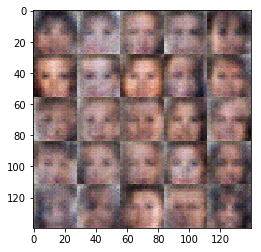

Epoch 1/1... Batch 210... Discriminator Loss: 1.0304... Generator Loss: 1.4772
Epoch 1/1... Batch 220... Discriminator Loss: 0.5422... Generator Loss: 3.3521
Epoch 1/1... Batch 230... Discriminator Loss: 1.0308... Generator Loss: 0.9395
Epoch 1/1... Batch 240... Discriminator Loss: 1.8443... Generator Loss: 0.3634
Epoch 1/1... Batch 250... Discriminator Loss: 0.9362... Generator Loss: 1.1677


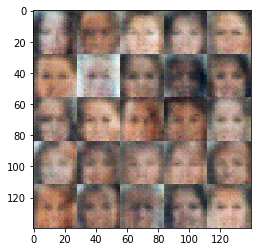

Epoch 1/1... Batch 260... Discriminator Loss: 0.7477... Generator Loss: 3.7819
Epoch 1/1... Batch 270... Discriminator Loss: 1.0587... Generator Loss: 0.7279
Epoch 1/1... Batch 280... Discriminator Loss: 0.5643... Generator Loss: 5.4796
Epoch 1/1... Batch 290... Discriminator Loss: 0.5219... Generator Loss: 6.5231
Epoch 1/1... Batch 300... Discriminator Loss: 0.7773... Generator Loss: 7.4392


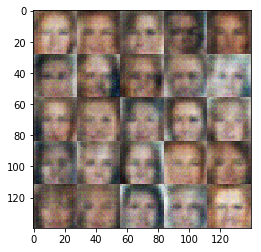

Epoch 1/1... Batch 310... Discriminator Loss: 0.5527... Generator Loss: 2.1503
Epoch 1/1... Batch 320... Discriminator Loss: 0.4539... Generator Loss: 3.0791
Epoch 1/1... Batch 330... Discriminator Loss: 1.9670... Generator Loss: 5.6719
Epoch 1/1... Batch 340... Discriminator Loss: 1.6214... Generator Loss: 1.5028
Epoch 1/1... Batch 350... Discriminator Loss: 0.4407... Generator Loss: 2.8231


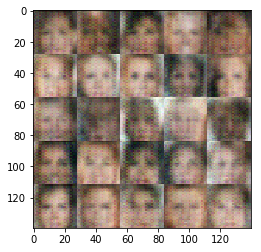

Epoch 1/1... Batch 360... Discriminator Loss: 1.2809... Generator Loss: 0.5679
Epoch 1/1... Batch 370... Discriminator Loss: 0.3675... Generator Loss: 3.7608
Epoch 1/1... Batch 380... Discriminator Loss: 1.4810... Generator Loss: 0.4257
Epoch 1/1... Batch 390... Discriminator Loss: 1.6830... Generator Loss: 1.2612
Epoch 1/1... Batch 400... Discriminator Loss: 0.8901... Generator Loss: 5.8669


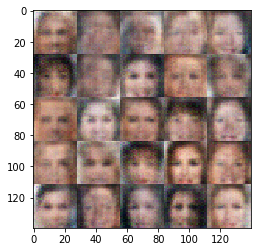

Epoch 1/1... Batch 410... Discriminator Loss: 1.1488... Generator Loss: 0.7101
Epoch 1/1... Batch 420... Discriminator Loss: 0.7403... Generator Loss: 1.2055
Epoch 1/1... Batch 430... Discriminator Loss: 1.0184... Generator Loss: 0.8497
Epoch 1/1... Batch 440... Discriminator Loss: 0.5923... Generator Loss: 7.3388
Epoch 1/1... Batch 450... Discriminator Loss: 1.1672... Generator Loss: 1.7036


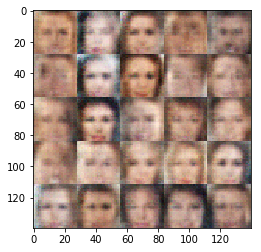

Epoch 1/1... Batch 460... Discriminator Loss: 0.6222... Generator Loss: 1.4949
Epoch 1/1... Batch 470... Discriminator Loss: 1.1954... Generator Loss: 0.7879
Epoch 1/1... Batch 480... Discriminator Loss: 1.3988... Generator Loss: 0.5100
Epoch 1/1... Batch 490... Discriminator Loss: 0.9817... Generator Loss: 5.9713
Epoch 1/1... Batch 500... Discriminator Loss: 0.8690... Generator Loss: 1.0571


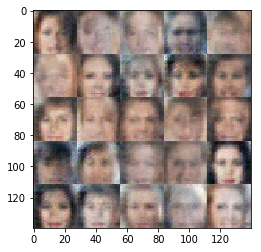

Epoch 1/1... Batch 510... Discriminator Loss: 1.0068... Generator Loss: 2.5429
Epoch 1/1... Batch 520... Discriminator Loss: 0.7834... Generator Loss: 1.6320
Epoch 1/1... Batch 530... Discriminator Loss: 1.4575... Generator Loss: 0.4414
Epoch 1/1... Batch 540... Discriminator Loss: 0.8809... Generator Loss: 2.0385
Epoch 1/1... Batch 550... Discriminator Loss: 0.8850... Generator Loss: 1.0135


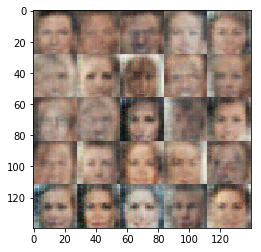

Epoch 1/1... Batch 560... Discriminator Loss: 0.7829... Generator Loss: 2.7596
Epoch 1/1... Batch 570... Discriminator Loss: 1.1684... Generator Loss: 0.6467
Epoch 1/1... Batch 580... Discriminator Loss: 0.4951... Generator Loss: 2.5878
Epoch 1/1... Batch 590... Discriminator Loss: 0.8438... Generator Loss: 1.2048
Epoch 1/1... Batch 600... Discriminator Loss: 0.6242... Generator Loss: 2.1160


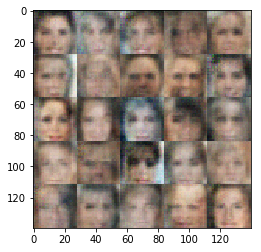

Epoch 1/1... Batch 610... Discriminator Loss: 0.8500... Generator Loss: 1.0518
Epoch 1/1... Batch 620... Discriminator Loss: 0.4520... Generator Loss: 3.1424
Epoch 1/1... Batch 630... Discriminator Loss: 0.7975... Generator Loss: 3.8033
Epoch 1/1... Batch 640... Discriminator Loss: 2.1602... Generator Loss: 0.2189
Epoch 1/1... Batch 650... Discriminator Loss: 0.6060... Generator Loss: 5.9471


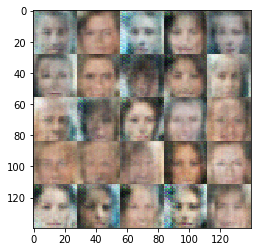

Epoch 1/1... Batch 660... Discriminator Loss: 1.2939... Generator Loss: 0.5835
Epoch 1/1... Batch 670... Discriminator Loss: 0.5309... Generator Loss: 2.1514
Epoch 1/1... Batch 680... Discriminator Loss: 0.8166... Generator Loss: 2.9467
Epoch 1/1... Batch 690... Discriminator Loss: 0.6652... Generator Loss: 1.4391
Epoch 1/1... Batch 700... Discriminator Loss: 0.7582... Generator Loss: 1.3883


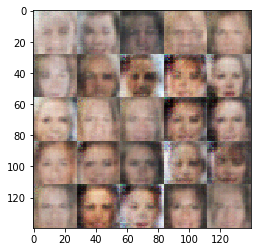

Epoch 1/1... Batch 710... Discriminator Loss: 0.6294... Generator Loss: 1.8711
Epoch 1/1... Batch 720... Discriminator Loss: 0.4851... Generator Loss: 4.6904
Epoch 1/1... Batch 730... Discriminator Loss: 2.1340... Generator Loss: 4.1973
Epoch 1/1... Batch 740... Discriminator Loss: 0.6900... Generator Loss: 1.8851
Epoch 1/1... Batch 750... Discriminator Loss: 0.5091... Generator Loss: 2.5746


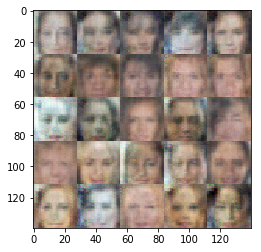

Epoch 1/1... Batch 760... Discriminator Loss: 0.8355... Generator Loss: 3.9395
Epoch 1/1... Batch 770... Discriminator Loss: 0.4187... Generator Loss: 3.9843
Epoch 1/1... Batch 780... Discriminator Loss: 0.5868... Generator Loss: 2.2315
Epoch 1/1... Batch 790... Discriminator Loss: 0.9890... Generator Loss: 0.9273
Epoch 1/1... Batch 800... Discriminator Loss: 0.6985... Generator Loss: 2.7977


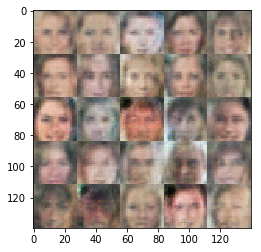

Epoch 1/1... Batch 810... Discriminator Loss: 0.4153... Generator Loss: 4.6780
Epoch 1/1... Batch 820... Discriminator Loss: 0.6491... Generator Loss: 1.7822
Epoch 1/1... Batch 830... Discriminator Loss: 0.7295... Generator Loss: 3.0072
Epoch 1/1... Batch 840... Discriminator Loss: 1.2415... Generator Loss: 1.9062
Epoch 1/1... Batch 850... Discriminator Loss: 0.4589... Generator Loss: 3.3576


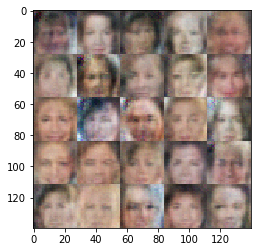

Epoch 1/1... Batch 860... Discriminator Loss: 1.0738... Generator Loss: 0.8693
Epoch 1/1... Batch 870... Discriminator Loss: 1.0283... Generator Loss: 1.3137
Epoch 1/1... Batch 880... Discriminator Loss: 1.0578... Generator Loss: 0.9809
Epoch 1/1... Batch 890... Discriminator Loss: 0.7138... Generator Loss: 1.5670
Epoch 1/1... Batch 900... Discriminator Loss: 0.4114... Generator Loss: 4.2878


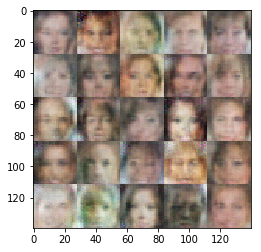

Epoch 1/1... Batch 910... Discriminator Loss: 2.1487... Generator Loss: 5.9183
Epoch 1/1... Batch 920... Discriminator Loss: 0.8987... Generator Loss: 1.3245
Epoch 1/1... Batch 930... Discriminator Loss: 0.5683... Generator Loss: 2.3009
Epoch 1/1... Batch 940... Discriminator Loss: 0.4174... Generator Loss: 5.0972
Epoch 1/1... Batch 950... Discriminator Loss: 0.6844... Generator Loss: 2.5629


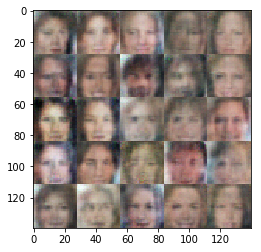

Epoch 1/1... Batch 960... Discriminator Loss: 0.8288... Generator Loss: 1.2143
Epoch 1/1... Batch 970... Discriminator Loss: 1.8445... Generator Loss: 0.2829
Epoch 1/1... Batch 980... Discriminator Loss: 0.9333... Generator Loss: 2.1928
Epoch 1/1... Batch 990... Discriminator Loss: 0.8686... Generator Loss: 2.3969
Epoch 1/1... Batch 1000... Discriminator Loss: 0.3852... Generator Loss: 5.0654


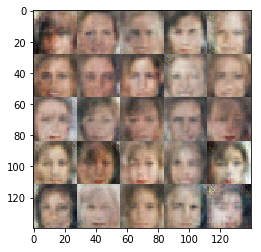

Epoch 1/1... Batch 1010... Discriminator Loss: 0.6147... Generator Loss: 2.0006
Epoch 1/1... Batch 1020... Discriminator Loss: 0.4064... Generator Loss: 3.7864
Epoch 1/1... Batch 1030... Discriminator Loss: 1.3154... Generator Loss: 0.6652
Epoch 1/1... Batch 1040... Discriminator Loss: 0.5686... Generator Loss: 2.0542
Epoch 1/1... Batch 1050... Discriminator Loss: 1.2301... Generator Loss: 2.4041


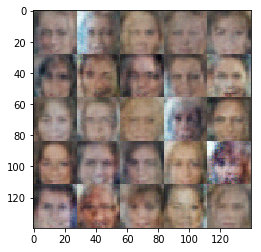

Epoch 1/1... Batch 1060... Discriminator Loss: 0.4080... Generator Loss: 2.9718
Epoch 1/1... Batch 1070... Discriminator Loss: 0.8671... Generator Loss: 2.9834
Epoch 1/1... Batch 1080... Discriminator Loss: 0.5003... Generator Loss: 3.7073
Epoch 1/1... Batch 1090... Discriminator Loss: 0.7475... Generator Loss: 2.2978
Epoch 1/1... Batch 1100... Discriminator Loss: 2.1060... Generator Loss: 0.4201


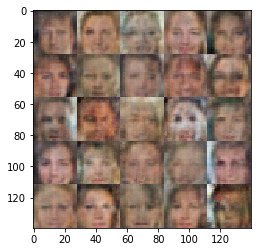

Epoch 1/1... Batch 1110... Discriminator Loss: 1.2577... Generator Loss: 1.1372
Epoch 1/1... Batch 1120... Discriminator Loss: 1.2061... Generator Loss: 1.8327
Epoch 1/1... Batch 1130... Discriminator Loss: 1.6410... Generator Loss: 0.4124
Epoch 1/1... Batch 1140... Discriminator Loss: 1.2485... Generator Loss: 0.7894
Epoch 1/1... Batch 1150... Discriminator Loss: 0.7361... Generator Loss: 1.7294


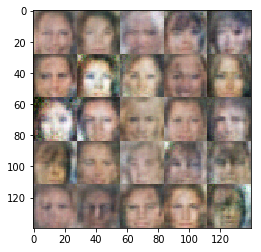

Epoch 1/1... Batch 1160... Discriminator Loss: 0.8535... Generator Loss: 1.1939
Epoch 1/1... Batch 1170... Discriminator Loss: 0.6678... Generator Loss: 2.6124
Epoch 1/1... Batch 1180... Discriminator Loss: 0.7833... Generator Loss: 1.3211
Epoch 1/1... Batch 1190... Discriminator Loss: 0.4886... Generator Loss: 2.9990
Epoch 1/1... Batch 1200... Discriminator Loss: 0.3772... Generator Loss: 4.3825


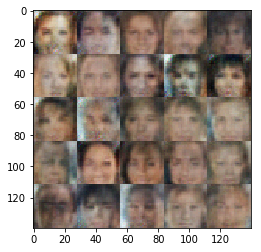

Epoch 1/1... Batch 1210... Discriminator Loss: 0.6436... Generator Loss: 2.0967
Epoch 1/1... Batch 1220... Discriminator Loss: 0.4513... Generator Loss: 4.4011
Epoch 1/1... Batch 1230... Discriminator Loss: 0.7689... Generator Loss: 4.0257
Epoch 1/1... Batch 1240... Discriminator Loss: 0.4317... Generator Loss: 3.1921
Epoch 1/1... Batch 1250... Discriminator Loss: 0.3619... Generator Loss: 7.9071


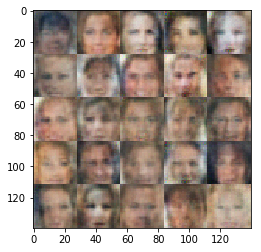

Epoch 1/1... Batch 1260... Discriminator Loss: 0.5748... Generator Loss: 3.1456
Epoch 1/1... Batch 1270... Discriminator Loss: 0.4015... Generator Loss: 4.0777
Epoch 1/1... Batch 1280... Discriminator Loss: 0.3943... Generator Loss: 3.1325
Epoch 1/1... Batch 1290... Discriminator Loss: 0.5307... Generator Loss: 2.4531
Epoch 1/1... Batch 1300... Discriminator Loss: 1.2990... Generator Loss: 0.6872


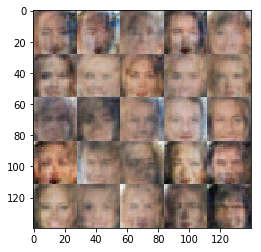

Epoch 1/1... Batch 1310... Discriminator Loss: 1.6308... Generator Loss: 0.5346
Epoch 1/1... Batch 1320... Discriminator Loss: 1.1798... Generator Loss: 0.9743
Epoch 1/1... Batch 1330... Discriminator Loss: 1.4494... Generator Loss: 0.6377
Epoch 1/1... Batch 1340... Discriminator Loss: 1.4780... Generator Loss: 0.7329
Epoch 1/1... Batch 1350... Discriminator Loss: 0.8864... Generator Loss: 2.0925


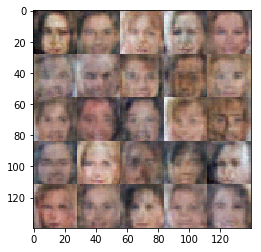

Epoch 1/1... Batch 1360... Discriminator Loss: 0.8857... Generator Loss: 4.7978
Epoch 1/1... Batch 1370... Discriminator Loss: 1.6627... Generator Loss: 3.0771
Epoch 1/1... Batch 1380... Discriminator Loss: 1.0499... Generator Loss: 0.9292
Epoch 1/1... Batch 1390... Discriminator Loss: 1.2045... Generator Loss: 3.1208
Epoch 1/1... Batch 1400... Discriminator Loss: 0.5167... Generator Loss: 3.3020


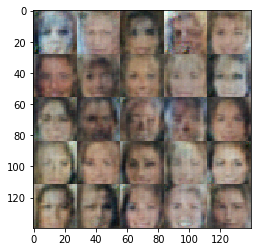

Epoch 1/1... Batch 1410... Discriminator Loss: 1.5341... Generator Loss: 3.0626
Epoch 1/1... Batch 1420... Discriminator Loss: 1.1216... Generator Loss: 0.9466
Epoch 1/1... Batch 1430... Discriminator Loss: 0.7610... Generator Loss: 1.9869
Epoch 1/1... Batch 1440... Discriminator Loss: 1.0910... Generator Loss: 0.7091
Epoch 1/1... Batch 1450... Discriminator Loss: 0.8134... Generator Loss: 1.3271


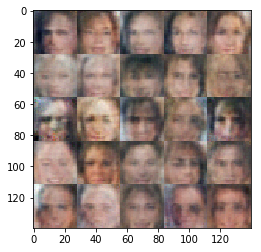

Epoch 1/1... Batch 1460... Discriminator Loss: 0.4279... Generator Loss: 3.5534
Epoch 1/1... Batch 1470... Discriminator Loss: 0.6770... Generator Loss: 1.9107
Epoch 1/1... Batch 1480... Discriminator Loss: 1.6101... Generator Loss: 0.4063
Epoch 1/1... Batch 1490... Discriminator Loss: 0.5230... Generator Loss: 3.1638
Epoch 1/1... Batch 1500... Discriminator Loss: 1.0318... Generator Loss: 0.8567


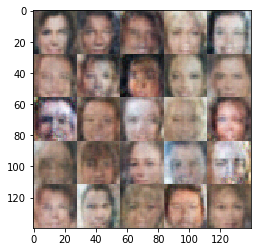

Epoch 1/1... Batch 1510... Discriminator Loss: 0.8984... Generator Loss: 1.0391
Epoch 1/1... Batch 1520... Discriminator Loss: 0.3414... Generator Loss: 7.3874
Epoch 1/1... Batch 1530... Discriminator Loss: 0.3433... Generator Loss: 8.4091
Epoch 1/1... Batch 1540... Discriminator Loss: 3.1251... Generator Loss: 3.7343
Epoch 1/1... Batch 1550... Discriminator Loss: 0.3801... Generator Loss: 4.5707


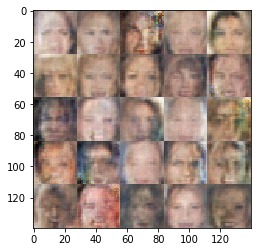

Epoch 1/1... Batch 1560... Discriminator Loss: 1.3720... Generator Loss: 0.5250
Epoch 1/1... Batch 1570... Discriminator Loss: 0.3723... Generator Loss: 4.5646
Epoch 1/1... Batch 1580... Discriminator Loss: 0.7541... Generator Loss: 5.6450
Epoch 1/1... Batch 1590... Discriminator Loss: 0.3911... Generator Loss: 4.1457
Epoch 1/1... Batch 1600... Discriminator Loss: 0.7582... Generator Loss: 6.1328


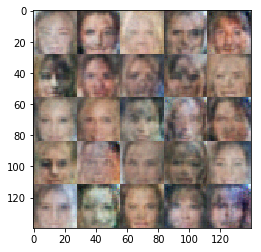

Epoch 1/1... Batch 1610... Discriminator Loss: 0.4130... Generator Loss: 3.0414
Epoch 1/1... Batch 1620... Discriminator Loss: 0.5411... Generator Loss: 2.1281
Epoch 1/1... Batch 1630... Discriminator Loss: 0.7657... Generator Loss: 1.3378
Epoch 1/1... Batch 1640... Discriminator Loss: 1.4524... Generator Loss: 5.1882
Epoch 1/1... Batch 1650... Discriminator Loss: 0.5095... Generator Loss: 2.4467


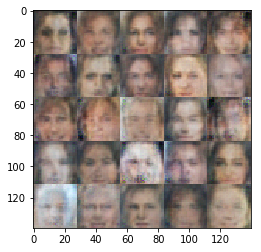

Epoch 1/1... Batch 1660... Discriminator Loss: 0.6784... Generator Loss: 8.5689
Epoch 1/1... Batch 1670... Discriminator Loss: 0.3810... Generator Loss: 4.7462
Epoch 1/1... Batch 1680... Discriminator Loss: 0.6711... Generator Loss: 2.1773
Epoch 1/1... Batch 1690... Discriminator Loss: 0.7107... Generator Loss: 1.7290
Epoch 1/1... Batch 1700... Discriminator Loss: 0.8936... Generator Loss: 5.9330


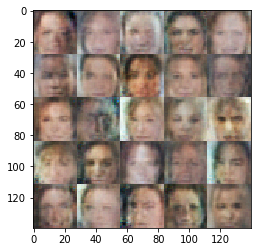

Epoch 1/1... Batch 1710... Discriminator Loss: 0.4529... Generator Loss: 4.5801
Epoch 1/1... Batch 1720... Discriminator Loss: 1.7184... Generator Loss: 0.3623
Epoch 1/1... Batch 1730... Discriminator Loss: 1.1390... Generator Loss: 0.7444
Epoch 1/1... Batch 1740... Discriminator Loss: 1.3220... Generator Loss: 1.1609
Epoch 1/1... Batch 1750... Discriminator Loss: 1.4018... Generator Loss: 0.5170


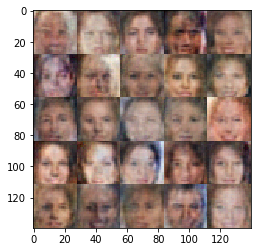

Epoch 1/1... Batch 1760... Discriminator Loss: 0.3952... Generator Loss: 4.0128
Epoch 1/1... Batch 1770... Discriminator Loss: 0.5838... Generator Loss: 1.9940
Epoch 1/1... Batch 1780... Discriminator Loss: 0.3676... Generator Loss: 4.9617
Epoch 1/1... Batch 1790... Discriminator Loss: 0.3876... Generator Loss: 3.8752
Epoch 1/1... Batch 1800... Discriminator Loss: 0.4817... Generator Loss: 4.3745


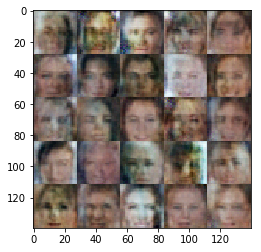

Epoch 1/1... Batch 1810... Discriminator Loss: 0.3981... Generator Loss: 3.7993
Epoch 1/1... Batch 1820... Discriminator Loss: 0.7073... Generator Loss: 1.3704
Epoch 1/1... Batch 1830... Discriminator Loss: 0.9253... Generator Loss: 3.7361
Epoch 1/1... Batch 1840... Discriminator Loss: 1.2005... Generator Loss: 3.2161
Epoch 1/1... Batch 1850... Discriminator Loss: 0.4345... Generator Loss: 3.3976


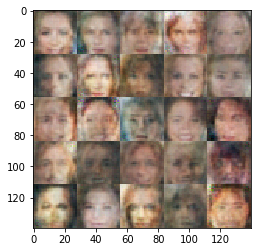

Epoch 1/1... Batch 1860... Discriminator Loss: 0.3471... Generator Loss: 7.9709
Epoch 1/1... Batch 1870... Discriminator Loss: 0.5580... Generator Loss: 7.9199
Epoch 1/1... Batch 1880... Discriminator Loss: 0.3630... Generator Loss: 4.7111
Epoch 1/1... Batch 1890... Discriminator Loss: 0.6690... Generator Loss: 4.9064
Epoch 1/1... Batch 1900... Discriminator Loss: 0.3656... Generator Loss: 7.4936


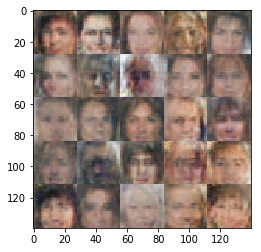

Epoch 1/1... Batch 1910... Discriminator Loss: 0.4890... Generator Loss: 2.3561
Epoch 1/1... Batch 1920... Discriminator Loss: 1.0851... Generator Loss: 4.9878
Epoch 1/1... Batch 1930... Discriminator Loss: 0.3842... Generator Loss: 4.0295
Epoch 1/1... Batch 1940... Discriminator Loss: 0.5333... Generator Loss: 2.1545
Epoch 1/1... Batch 1950... Discriminator Loss: 0.3824... Generator Loss: 3.5195


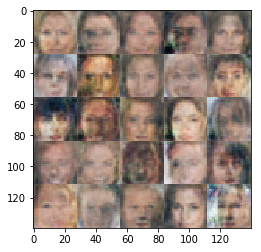

Epoch 1/1... Batch 1960... Discriminator Loss: 1.7870... Generator Loss: 5.1371
Epoch 1/1... Batch 1970... Discriminator Loss: 0.4989... Generator Loss: 2.5068
Epoch 1/1... Batch 1980... Discriminator Loss: 0.4161... Generator Loss: 5.0096
Epoch 1/1... Batch 1990... Discriminator Loss: 0.4963... Generator Loss: 2.3692
Epoch 1/1... Batch 2000... Discriminator Loss: 0.4082... Generator Loss: 4.2039


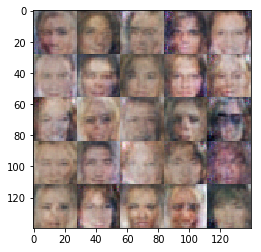

Epoch 1/1... Batch 2010... Discriminator Loss: 0.7479... Generator Loss: 1.2346
Epoch 1/1... Batch 2020... Discriminator Loss: 1.8689... Generator Loss: 1.3213
Epoch 1/1... Batch 2030... Discriminator Loss: 0.8970... Generator Loss: 2.9202
Epoch 1/1... Batch 2040... Discriminator Loss: 1.2864... Generator Loss: 0.6182
Epoch 1/1... Batch 2050... Discriminator Loss: 1.1968... Generator Loss: 0.6947


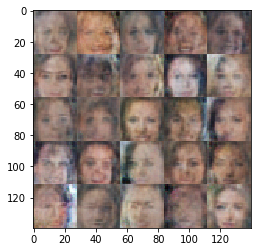

Epoch 1/1... Batch 2060... Discriminator Loss: 1.4718... Generator Loss: 0.6671
Epoch 1/1... Batch 2070... Discriminator Loss: 0.9118... Generator Loss: 2.2071
Epoch 1/1... Batch 2080... Discriminator Loss: 1.0133... Generator Loss: 1.1089
Epoch 1/1... Batch 2090... Discriminator Loss: 0.9809... Generator Loss: 0.9754
Epoch 1/1... Batch 2100... Discriminator Loss: 0.5545... Generator Loss: 2.1929


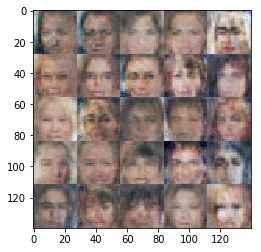

Epoch 1/1... Batch 2110... Discriminator Loss: 0.3582... Generator Loss: 5.3590
Epoch 1/1... Batch 2120... Discriminator Loss: 0.3829... Generator Loss: 8.3891
Epoch 1/1... Batch 2130... Discriminator Loss: 0.4327... Generator Loss: 3.1217
Epoch 1/1... Batch 2140... Discriminator Loss: 0.4013... Generator Loss: 4.0946
Epoch 1/1... Batch 2150... Discriminator Loss: 0.4592... Generator Loss: 3.4062


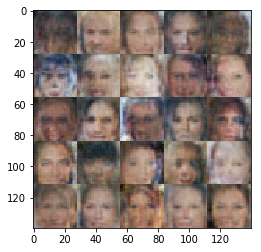

Epoch 1/1... Batch 2160... Discriminator Loss: 1.3224... Generator Loss: 0.7845
Epoch 1/1... Batch 2170... Discriminator Loss: 1.0021... Generator Loss: 1.1643
Epoch 1/1... Batch 2180... Discriminator Loss: 0.7651... Generator Loss: 1.4029
Epoch 1/1... Batch 2190... Discriminator Loss: 0.6250... Generator Loss: 1.7858
Epoch 1/1... Batch 2200... Discriminator Loss: 0.4055... Generator Loss: 3.4938


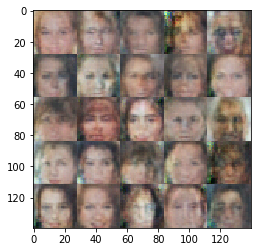

Epoch 1/1... Batch 2210... Discriminator Loss: 0.3762... Generator Loss: 4.8084
Epoch 1/1... Batch 2220... Discriminator Loss: 1.3222... Generator Loss: 5.3470
Epoch 1/1... Batch 2230... Discriminator Loss: 1.2175... Generator Loss: 0.7958
Epoch 1/1... Batch 2240... Discriminator Loss: 1.1243... Generator Loss: 0.8323
Epoch 1/1... Batch 2250... Discriminator Loss: 0.7139... Generator Loss: 1.6026


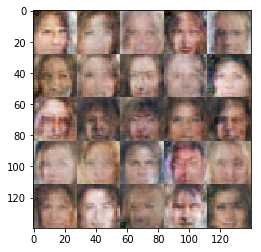

Epoch 1/1... Batch 2260... Discriminator Loss: 0.7947... Generator Loss: 3.8313
Epoch 1/1... Batch 2270... Discriminator Loss: 0.4450... Generator Loss: 3.5195
Epoch 1/1... Batch 2280... Discriminator Loss: 0.4496... Generator Loss: 4.4753
Epoch 1/1... Batch 2290... Discriminator Loss: 0.4271... Generator Loss: 3.5580
Epoch 1/1... Batch 2300... Discriminator Loss: 0.4264... Generator Loss: 3.0827


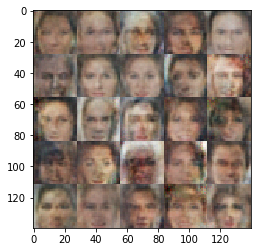

Epoch 1/1... Batch 2310... Discriminator Loss: 0.3623... Generator Loss: 6.0584
Epoch 1/1... Batch 2320... Discriminator Loss: 1.0330... Generator Loss: 1.0821
Epoch 1/1... Batch 2330... Discriminator Loss: 0.6007... Generator Loss: 2.3111
Epoch 1/1... Batch 2340... Discriminator Loss: 0.4521... Generator Loss: 2.7937
Epoch 1/1... Batch 2350... Discriminator Loss: 0.3964... Generator Loss: 3.3739


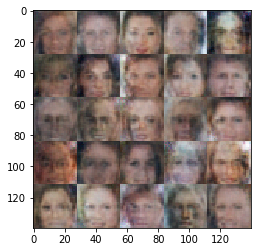

Epoch 1/1... Batch 2360... Discriminator Loss: 0.4225... Generator Loss: 4.2594
Epoch 1/1... Batch 2370... Discriminator Loss: 0.6477... Generator Loss: 2.0520
Epoch 1/1... Batch 2380... Discriminator Loss: 0.3737... Generator Loss: 4.1945
Epoch 1/1... Batch 2390... Discriminator Loss: 0.5315... Generator Loss: 2.2343
Epoch 1/1... Batch 2400... Discriminator Loss: 0.3528... Generator Loss: 4.9125


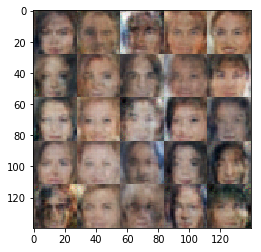

Epoch 1/1... Batch 2410... Discriminator Loss: 0.5039... Generator Loss: 2.8922
Epoch 1/1... Batch 2420... Discriminator Loss: 0.6104... Generator Loss: 1.9770
Epoch 1/1... Batch 2430... Discriminator Loss: 0.3477... Generator Loss: 8.0347
Epoch 1/1... Batch 2440... Discriminator Loss: 0.5819... Generator Loss: 1.9760
Epoch 1/1... Batch 2450... Discriminator Loss: 0.3690... Generator Loss: 6.5921


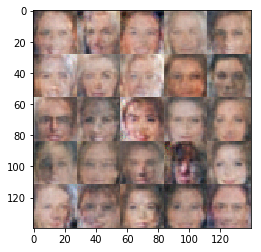

Epoch 1/1... Batch 2460... Discriminator Loss: 0.4585... Generator Loss: 3.3858
Epoch 1/1... Batch 2470... Discriminator Loss: 2.5292... Generator Loss: 2.4839
Epoch 1/1... Batch 2480... Discriminator Loss: 1.4492... Generator Loss: 0.8922
Epoch 1/1... Batch 2490... Discriminator Loss: 1.2467... Generator Loss: 0.9056
Epoch 1/1... Batch 2500... Discriminator Loss: 1.4268... Generator Loss: 0.7439


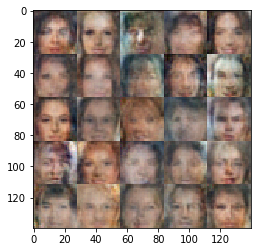

Epoch 1/1... Batch 2510... Discriminator Loss: 1.8580... Generator Loss: 0.2816
Epoch 1/1... Batch 2520... Discriminator Loss: 1.4150... Generator Loss: 2.0132
Epoch 1/1... Batch 2530... Discriminator Loss: 0.8835... Generator Loss: 1.7787
Epoch 1/1... Batch 2540... Discriminator Loss: 0.9596... Generator Loss: 1.1368
Epoch 1/1... Batch 2550... Discriminator Loss: 1.9029... Generator Loss: 2.6485


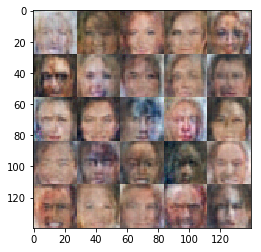

Epoch 1/1... Batch 2560... Discriminator Loss: 1.2520... Generator Loss: 0.6816
Epoch 1/1... Batch 2570... Discriminator Loss: 1.2860... Generator Loss: 0.7205
Epoch 1/1... Batch 2580... Discriminator Loss: 1.4082... Generator Loss: 0.6806
Epoch 1/1... Batch 2590... Discriminator Loss: 1.4036... Generator Loss: 0.7671
Epoch 1/1... Batch 2600... Discriminator Loss: 0.4853... Generator Loss: 3.9189


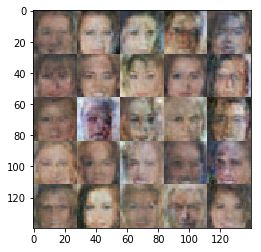

Epoch 1/1... Batch 2610... Discriminator Loss: 0.7320... Generator Loss: 1.3478
Epoch 1/1... Batch 2620... Discriminator Loss: 2.6423... Generator Loss: 0.1371
Epoch 1/1... Batch 2630... Discriminator Loss: 0.6502... Generator Loss: 2.8185
Epoch 1/1... Batch 2640... Discriminator Loss: 1.4711... Generator Loss: 6.4539
Epoch 1/1... Batch 2650... Discriminator Loss: 0.5421... Generator Loss: 2.3562


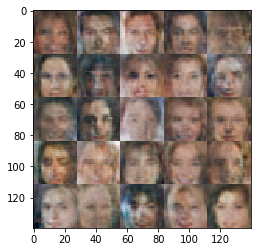

Epoch 1/1... Batch 2660... Discriminator Loss: 0.5583... Generator Loss: 3.9439
Epoch 1/1... Batch 2670... Discriminator Loss: 0.6207... Generator Loss: 1.6449
Epoch 1/1... Batch 2680... Discriminator Loss: 0.4288... Generator Loss: 3.2632
Epoch 1/1... Batch 2690... Discriminator Loss: 0.3701... Generator Loss: 5.9746
Epoch 1/1... Batch 2700... Discriminator Loss: 0.4744... Generator Loss: 2.8593


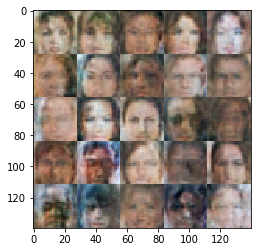

Epoch 1/1... Batch 2710... Discriminator Loss: 0.3504... Generator Loss: 6.1714
Epoch 1/1... Batch 2720... Discriminator Loss: 0.3485... Generator Loss: 7.2773
Epoch 1/1... Batch 2730... Discriminator Loss: 0.5748... Generator Loss: 3.1920
Epoch 1/1... Batch 2740... Discriminator Loss: 2.6429... Generator Loss: 3.7545
Epoch 1/1... Batch 2750... Discriminator Loss: 0.9124... Generator Loss: 1.0344


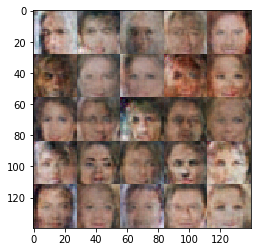

Epoch 1/1... Batch 2760... Discriminator Loss: 0.4231... Generator Loss: 3.0336
Epoch 1/1... Batch 2770... Discriminator Loss: 0.5095... Generator Loss: 3.6285
Epoch 1/1... Batch 2780... Discriminator Loss: 1.2858... Generator Loss: 0.7237
Epoch 1/1... Batch 2790... Discriminator Loss: 0.5361... Generator Loss: 2.8732
Epoch 1/1... Batch 2800... Discriminator Loss: 0.3836... Generator Loss: 3.6220


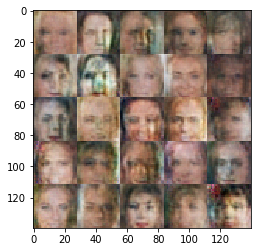

Epoch 1/1... Batch 2810... Discriminator Loss: 0.3689... Generator Loss: 4.4856
Epoch 1/1... Batch 2820... Discriminator Loss: 0.4704... Generator Loss: 2.8940
Epoch 1/1... Batch 2830... Discriminator Loss: 3.0960... Generator Loss: 0.0914
Epoch 1/1... Batch 2840... Discriminator Loss: 1.2653... Generator Loss: 0.7967
Epoch 1/1... Batch 2850... Discriminator Loss: 1.0832... Generator Loss: 1.0175


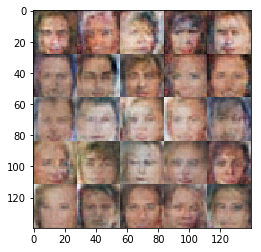

Epoch 1/1... Batch 2860... Discriminator Loss: 1.3316... Generator Loss: 0.7481
Epoch 1/1... Batch 2870... Discriminator Loss: 0.9079... Generator Loss: 1.1129
Epoch 1/1... Batch 2880... Discriminator Loss: 0.7843... Generator Loss: 1.5016
Epoch 1/1... Batch 2890... Discriminator Loss: 1.9741... Generator Loss: 0.2810
Epoch 1/1... Batch 2900... Discriminator Loss: 1.3743... Generator Loss: 0.5120


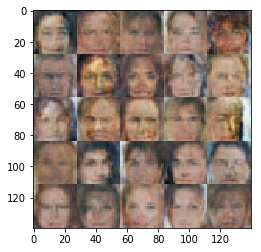

Epoch 1/1... Batch 2910... Discriminator Loss: 0.7883... Generator Loss: 1.1587
Epoch 1/1... Batch 2920... Discriminator Loss: 1.6193... Generator Loss: 0.3947
Epoch 1/1... Batch 2930... Discriminator Loss: 0.7977... Generator Loss: 1.2774
Epoch 1/1... Batch 2940... Discriminator Loss: 0.4129... Generator Loss: 4.1226
Epoch 1/1... Batch 2950... Discriminator Loss: 0.9264... Generator Loss: 0.9895


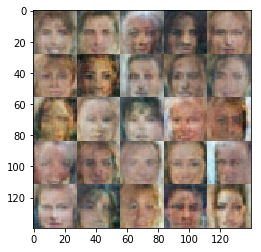

Epoch 1/1... Batch 2960... Discriminator Loss: 1.3569... Generator Loss: 0.6132
Epoch 1/1... Batch 2970... Discriminator Loss: 1.4012... Generator Loss: 0.4913
Epoch 1/1... Batch 2980... Discriminator Loss: 1.0319... Generator Loss: 0.8590
Epoch 1/1... Batch 2990... Discriminator Loss: 0.4571... Generator Loss: 2.8101
Epoch 1/1... Batch 3000... Discriminator Loss: 0.4505... Generator Loss: 4.9774


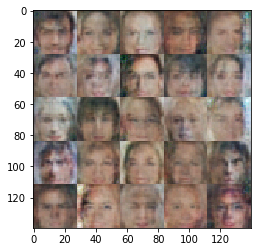

Epoch 1/1... Batch 3010... Discriminator Loss: 0.4067... Generator Loss: 3.2287
Epoch 1/1... Batch 3020... Discriminator Loss: 0.4305... Generator Loss: 3.2281
Epoch 1/1... Batch 3030... Discriminator Loss: 0.6084... Generator Loss: 2.0597
Epoch 1/1... Batch 3040... Discriminator Loss: 0.4983... Generator Loss: 2.1492
Epoch 1/1... Batch 3050... Discriminator Loss: 2.0287... Generator Loss: 0.3038


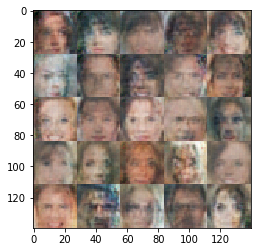

Epoch 1/1... Batch 3060... Discriminator Loss: 1.6399... Generator Loss: 0.5393
Epoch 1/1... Batch 3070... Discriminator Loss: 1.2174... Generator Loss: 0.8169
Epoch 1/1... Batch 3080... Discriminator Loss: 1.2485... Generator Loss: 0.6107
Epoch 1/1... Batch 3090... Discriminator Loss: 0.6327... Generator Loss: 1.8353
Epoch 1/1... Batch 3100... Discriminator Loss: 1.3380... Generator Loss: 0.7848


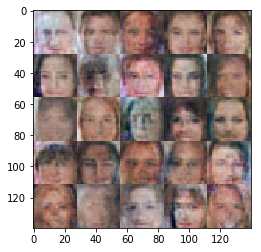

Epoch 1/1... Batch 3110... Discriminator Loss: 1.5657... Generator Loss: 0.4319
Epoch 1/1... Batch 3120... Discriminator Loss: 0.6576... Generator Loss: 1.7029
Epoch 1/1... Batch 3130... Discriminator Loss: 0.4802... Generator Loss: 2.6084
Epoch 1/1... Batch 3140... Discriminator Loss: 0.6597... Generator Loss: 1.6075
Epoch 1/1... Batch 3150... Discriminator Loss: 0.3697... Generator Loss: 6.0078


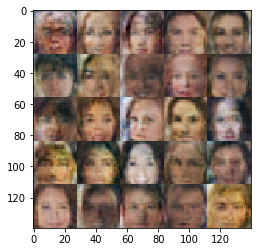

Epoch 1/1... Batch 3160... Discriminator Loss: 0.3410... Generator Loss: 7.8913


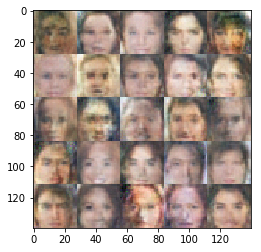

In [118]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.